In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
richprogress bar

Create a siamese network for immage classification

In [2]:
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm as tq
import matplotlib.pyplot as plt
from skimage.io import imshow
from pathlib import Path
import numpy as np
import random

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
#from torch.utils.tensorboard import SummaryWriter
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau


c:\Users\thoma\.conda\envs\deepL\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


load data

In [3]:
#/content/drive/MyDrive/Colab Notebooks/efficent net/
npz = np.load('data/input_data.npz')
X_train = npz['X_train']
Y_train = npz['Y_train']

del npz

print('We have {} examples to work with'.format(Y_train.shape[0]))

We have 4113 examples to work with


plot some data

In [4]:
# Plotting data
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

def plot_image(ix):
    imshow(np.squeeze(X_train[ix,:,:,2]))#Looking at the combined channel
    plt.show()
    labels = ['Ship','Iceberg']  #0 is no iceberg(ship) and 1 is iceberg
    print ('This is:',labels[int(Y_train[ix])])


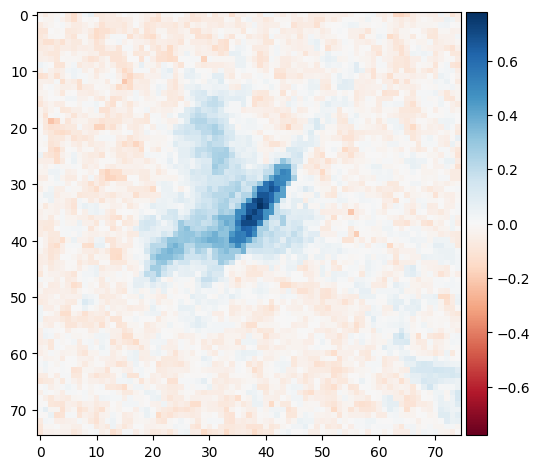

This is: Iceberg


In [5]:
plot_image(101)

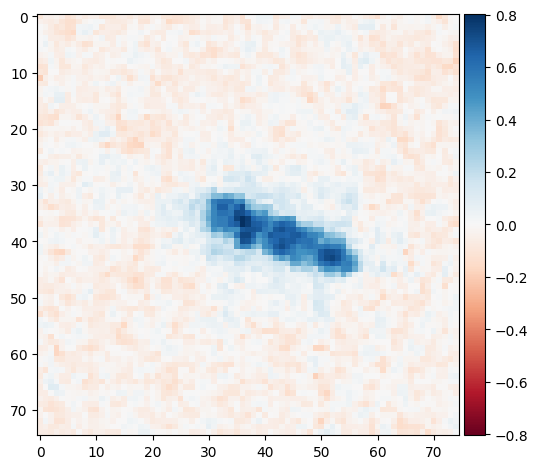

This is: Ship


In [6]:
plot_image(100)

create a base network

In [7]:
# Koch et al.   
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 128, 3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        
        self.dropout=nn.Dropout(p=0.5) 
        
        self.fc1=nn.Sequential(
            nn.Linear(1024, 512),
            nn.Sigmoid())
        
        self.out=nn.Linear(512,1)
        
    def forward_once(self,inp):
        inp=self.conv(inp)
        inp=inp.view(inp.size()[0], -1)
        inp = self.dropout(inp) #
        inp=self.fc1(inp)
        return inp

    def forward(self, inp1, inp2):
        out1=self.forward_once(inp1)
        out2=self.forward_once(inp2)
        dis=torch.abs(out2-out1)
        out=self.out(dis)
        return out

Create the pair of images to train on

In [8]:
class CustomImageDataset(Dataset):
    def __init__(self, left_list, right_list,targets, transform):
        self.left_dat = left_list
        self.right_dat = right_list
        self.targets = targets
        self.transform = transform
        self.imag_nomr = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        left_img = self.left_dat[idx]
        right_img = self.right_dat[idx]
        targets = self.targets[idx]
        
        left_img = np.transpose(left_img,(2,0,1))
        left_img = torch.Tensor(left_img)

        right_img = np.transpose(right_img,(2,0,1))
        right_img = torch.Tensor(right_img)

        # nomalization of immages
        left_img = self.imag_nomr(left_img)
        right_img = self.imag_nomr(right_img)
                        
        if self.transform:
            left_img = self.transform(left_img)
            right_img = self.transform(right_img)
    
        return left_img, right_img, targets




In [9]:
def crate_Pairs_data(image_list,label_list, pairs = 5):
    """

    """
    left_input = []
    right_input = []
    targets = []

    #Number of pairs per image
    pairs = pairs
    #Let's create the new dataset to train on
    for i in range(len(label_list)):
        for _ in range(pairs): 
            # compare the same immage on the left to different immages to the right
            compare_to = i 
            while compare_to == i: #Make sure it's not comparing to itself
                compare_to = random.randint(0,len(image_list)-1)

            left_img = image_list[i][0]
            right_img = image_list[compare_to][0]

            # create data sets
            left_input.append(np.array(left_img))
            right_input.append(np.array(right_img))

            if label_list[i] == label_list[compare_to]:# They are the same
                targets.append(1.)
            else:# Not the same
                targets.append(0.)
    
    return left_input,right_input,targets

In [10]:
X_index, y_index = range(X_train.shape[0]), range(Y_train.shape[0])
# test 20% 
X_train_index, X_test_index, y_train_index, y_test_index = train_test_split(X_index, y_index,
    test_size=0.2, shuffle = True, random_state = 42)

# validation 20% training 60%
X_train_index, X_val_index, y_train_index, y_val_index = train_test_split(X_train_index, y_train_index, 
    test_size=0.20, random_state= 42) # 0.25 x 0.8 = 0.2

In [11]:
len(X_train_index),len(X_val_index),len(X_test_index)


(2632, 658, 823)

Data augemtation

In [12]:
transform = torch.nn.Sequential(
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomGrayscale(0.5),
    )

Train data

In [13]:
image_list_train = np.split(X_train[X_train_index],len(X_train_index))
label_list_train = np.split(Y_train[y_train_index],len(y_train_index))
left_dat,right_dat,targets = crate_Pairs_data(image_list = image_list_train,label_list=label_list_train,pairs=5)
train_dataset = CustomImageDataset(left_list=left_dat,right_list=right_dat,targets=targets,transform=transform)

Validation data

In [14]:
image_list_val = np.split(X_train[X_val_index],len(X_val_index))
label_list_val = np.split(Y_train[y_val_index],len(y_val_index))
left_dat,right_dat,targets = crate_Pairs_data(image_list = image_list_val,label_list=label_list_val,pairs=5)
validation_dataset = CustomImageDataset(left_list=left_dat,right_list=right_dat,targets=targets,transform=None)

Test data

In [15]:
image_list_test = np.split(X_train[X_test_index],len(X_test_index))
label_list_test = np.split(Y_train[y_test_index],len(y_test_index))
left_dat,right_dat,targets = crate_Pairs_data(image_list = image_list_test,label_list=label_list_test,pairs=5)
test_dataset = CustomImageDataset(left_list=left_dat,right_list=right_dat,targets=targets,transform=None)

In [16]:
num_workers = 2
bs = 16
# Rest of the code goes the same

train_dataset_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=bs,shuffle=False, num_workers=num_workers)


validation_dataset_loader = torch.utils.data.DataLoader(
    validation_dataset, batch_size=bs, shuffle=False, num_workers=num_workers)

train model

In [17]:
net = SiameseNetwork()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.01, weight_decay = 2.5e-4 )
train_on_gpu = torch.cuda.is_available()
train_on_gpu

if train_on_gpu:
    net.cuda()

In [18]:
n_epochs = 10
train_loss_list = []
valid_loss_list = []
dice_score_list = []
lr_rate_list = []
counter = []
loss_history = [] 
iteration_number= 0
valid_loss_min = np.Inf 
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    sum_train_loss = 0.0
    sum_valid_loss = 0.0
    train_epoch_loss=0.0
    valid_epoch_loss = 0.0
    count = 0

    ###################
    #   MODEL TRAIN   #
    ###################
    net.train()
    bar = tq(train_dataset_loader, postfix={"train_loss":0.0})

    for img0, img1, label in bar:
        if train_on_gpu:
            img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
        optimizer.zero_grad()
        output = net(img0, img1)
        loss = criterion(output, label.unsqueeze(1))
        loss.backward()
        optimizer.step()
        train_epoch_loss = train_epoch_loss + ((1/(count+1)) * (loss.item() - train_epoch_loss))
        sum_train_loss += train_epoch_loss
        count += 1

        bar.set_postfix(ordered_dict={"train_loss": train_epoch_loss})
    
  
    iteration_number += 1
    counter.append(iteration_number)
    loss_history.append(train_epoch_loss)

    ######################    
    #  MODEL VALIDATION  #
    ######################
    net.eval()
    del img0, img1, label, bar
    count = 0

    with torch.no_grad():
        bar = tq(validation_dataset_loader, postfix={"valid_loss":0.0})
        for img0, img1, label in bar:
            
            if train_on_gpu:
                img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
            
            output = net(img0, img1)
            loss = criterion(output, label.unsqueeze(1))
            
            valid_epoch_loss = valid_epoch_loss + ((1/(count+1)) * (loss.item() - valid_epoch_loss))
            sum_valid_loss += valid_epoch_loss

            count += 1
            bar.set_postfix(ordered_dict={"valid_loss":loss.item()})
    

    train_loss_list.append(train_epoch_loss)
    valid_loss_list.append(valid_epoch_loss)
    lr_rate_list.append([param_group['lr'] for param_group in optimizer.param_groups])
    
    print("Average training loss after {} epochs : {}".format(epoch, sum_train_loss/len(train_dataset_loader)))
    print("Average validation loss after {} epochs : {}".format(epoch, sum_valid_loss/len(validation_dataset_loader)))


show_plot(counter, loss_history)

  0%|          | 0/823 [00:00<?, ?it/s, train_loss=0]

Evaluate on test set

In [ ]:
test_dataset_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1,shuffle=True, num_workers=2)


In [ ]:

with torch.no_grad():
    net.eval()
    correct=0
    count=0
    correct_count=0
    del img0, img1, label
    print("Testing...")
    bar = tq(validation_dataset_loader, postfix={"Accuracy":0.0})
    for img0, img1, label in bar:
        
        if train_on_gpu:
            img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
        
        output = net(img0, img1)
        prediction = torch.sigmoid(output)
        
        total = label.size(0)
        

        # check if prediction and actual label are same
        for j in range(output.size(0)):

            if (prediction[j]>0.5) and (label[j]==1):
            #if (output[j]>0) and (label[j]==1):
                correct+=1
            elif (prediction[j]<0.5) and (label[j]==0):
            #elif (output[j]<0.5) and (label[j]==0):
                correct+=1
            
        correct_count+=correct/total
        correct = 0
        count +=1 
        bar.set_postfix(ordered_dict={"Accuracy":(correct_count/count)*100})
        #imshow(torchvision.utils.make_grid(cat),'Pred : {:.2f} Label : {}'.format(prediction.item(),label.item()))   
        #imshow(torchvision.utils.make_grid(cat),'Pred : {:.2f} Label : {}'.format(output.item(),label.item()))   
print('{} correct predictions out of {}\nAccuracy : {:.2f}'.format(correct_count,count, (correct_count/count)*100))

Testing...


  0%|          | 0/258 [00:00<?, ?it/s, Accuracy=0]

127.85416666666667 correct predictions out of 258
Accuracy : 49.56
